<a href="https://colab.research.google.com/github/musicjae/korean_sentiment_analysis/blob/master/gru_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# References  
[1] # https://www.programcreek.com/python/example/106388/torchtext.data.Field
  
[2] https://simonjisu.github.io/nlp/2018/07/18/torchtext.html   

[3] https://wikidocs.net/44249


In [203]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import

In [204]:
!git clone https://github.com/e9t/nsmc.git

fatal: destination path 'nsmc' already exists and is not an empty directory.


In [205]:
!pip install konlpy

In [227]:
import pandas as pd
from konlpy.tag import Okt
from nltk import FreqDist
import numpy as np
from tqdm import tqdm
import random
import argparse
import torch
from collections import Counter
import datetime
now = datetime.datetime.now()

from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch
from torchtext import data
from torchtext.data import TabularDataset
from torchtext.data import Iterator
import warnings
warnings.filterwarnings(action='ignore')
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

In [207]:
random_seed=42
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
#torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

# args

In [346]:
USE_CUDA = torch.cuda.is_available()
print(USE_CUDA)

device = torch.device('cuda:0' if USE_CUDA else 'cpu')
print('학습을 진행하는 기기:',device)

parser = argparse.ArgumentParser(description='hyperparameters.....')
args = parser.parse_args("")

# =========== Training ============ #

args.batch_size = 64
args.epochs = 100
args.lr = 1e-3
args.eps = 1e-8
args.hidden_dim = 64
args.embbed_dim = 64
args.n_classes = 1
args.dropout_p = 0.3
args.n_layers = 1
args.patience = 10
args.max_len = 30

args.total_steps = 1055 * args.epochs  # 총 훈련 스텝 =  배치반복 횟수 * 에폭 where 1055 is len(train_loader)


True
학습을 진행하는 기기: cuda:0


# Dataset

In [209]:
train_dt = pd.read_csv("nsmc/ratings_train.txt", sep='\t')
test_dt = pd.read_csv("nsmc/ratings_test.txt", sep='\t')

train_path = 'nsmc/ratings_train.txt'
test_path = 'nsmc/ratings_test.txt'

### Preprocessing

In [210]:
def preprocess(text):

    text['document'] = text['document'].fillna(0)
    text['document'] = text['document'].str.replace(pat = r'[^ ㄱ-ㅣ가-힣]+', repl=r' ', regex=True) # 한글을 제외한 나머지 제거
    text['document'] = text['document'].str.replace(pat = r'[-=.#/?;$}]', repl=r' ', regex=True)
    text['document'] = text['document'].str.replace(',','').astype(object)
    
    text['document'] = text['document'].str.replace('ㅠㅠ','슬픔').astype(object)
    text['document'] = text['document'].str.replace('ㅠ ㅠ','슬픔').astype(object)
    text['document'] = text['document'].str.replace('ㅜ ㅜ','슬픔').astype(object)
    text['document'] = text['document'].str.replace('ㅎㄷㄷ','후덜덜').astype(object)
    text['document'] = text['document'].str.replace('ㅠ','슬픔').astype(object)
    text['document'] = text['document'].str.replace('ㅜ','슬픔').astype(object)
    text['document'] = text['document'].str.replace('ㅅㅅ','나이스').astype(object)
    text['document'] = text['document'].str.replace('ㅉㅉ','가엾다').astype(object)
    text['document'] = text['document'].str.replace('ㅜㅜ','슬픔').astype(object)
    text['document'] = text['document'].str.replace('ㅡㅡ','정색').astype(object)
    text['document'] = text['document'].str.replace('ㅋㅋ','웃김').astype(object)
    text['document'] = text['document'].str.replace('ㅎㅎ','신남').astype(object)
    text['document'] = text['document'].str.replace('ㅋ','').astype(object)
    text['document'] = text['document'].str.replace('ㅎ','').astype(object)

    return text

train_dt = preprocess(train_dt)
test_dt = preprocess(test_dt)

In [211]:
train_dt=train_dt[['document','label']]
print(len(train_dt))
test_dt=test_dt[['document','label']]

150000


In [212]:
train_y = train_dt.label
test_y = test_dt.label

In [213]:
len(test_y)

50000

### Custom Dataset

#### Tokenizing

In [88]:
a = [1,2,3,4]
b=[3,4,5,6,7]

res=[]
for i in b:
    if i not in a:
        res.append(i)

print(res)


[5, 6, 7]


In [221]:
tok = Okt()
def preprocessing_sen(sen):
    stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','이','영화','한','다',
 '적','만','으로','점','로','에서','과','것','그','게','이다','하는','고','거','요','뭐','까지','입니다','걸','이렇게',
 '임','라','인데', '듯','그리고','기','면','대','라고','이영화','분','이나','일','이고','여','고','두','를','을',
 '에게',
 '엔',
 '랑',
 '애',
 '라는']
    result=[]

    temp= tok.morphs(sen) 
    if temp not in stopwords:
        result.append(temp)

    return result    

In [220]:
def preprocessing_entirity(df):
    result = []
    for sen in tqdm(df.document):
        try:
            result.append(preprocessing_sen(sen))
        except:
            result.append('NaN')

    result = [x[0] for x in result]
    return result

processed_train = preprocessing_entirity(train_dt)
processed_test = preprocessing_entirity(test_dt)

100%|██████████| 50000/50000 [05:08<00:00, 162.25it/s]


In [352]:
pr_train = pd.Series(processed_train)
pr_test = pd.Series(processed_test)

pr_train.to_csv('/content/drive/MyDrive/Colab Notebooks/JJY/dataset/nsmc/preprocessed/train.csv')
pr_test.to_csv('/content/drive/MyDrive/Colab Notebooks/JJY/dataset/nsmc/preprocessed/test.csv')

#### Check stopwords

In [76]:
words = []

check_data = processed_train+processed_test
for sen in processed_train:
    for w in sen:
        #words.append(w)

#a = Counter(words)
#sorted(a.items(), key=lambda x: x[1], reverse=True)
#print(a)

Counter({'이': 56120, '영화': 50802, '의': 31041, '가': 27608, '에': 27187, '을': 23270, '도': 21214, '들': 19038, '는': 17605, '를': 16190, '은': 16100, '웃김': 14362, '너무': 11139, '한': 11005, '다': 10274, '정말': 9772, '적': 8757, '만': 8737, '진짜': 8346, '으로': 7943, '점': 7934, '로': 7860, '슬픔': 7649, '에서': 6993, '연기': 6433, '과': 6429, '평점': 6325, '것': 6315, '최고': 6036, '내': 6009, '나': 5746, '그': 5675, '잘': 5616, '안': 5557, '와': 5520, '인': 5499, '이런': 5422, '스토리': 5344, '생각': 5316, '못': 5302, '왜': 5160, '드라마': 5071, '게': 4969, '이다': 4961, '감동': 4881, '사람': 4839, '하는': 4741, '보고': 4708, '하고': 4686, '말': 4556, '고': 4534, '더': 4368, '아': 4332, '때': 4320, '배우': 4299, '감독': 4128, '거': 4125, '그냥': 4120, '요': 4049, '본': 4008, '재미': 3930, '시간': 3911, '내용': 3891, '뭐': 3832, '중': 3828, '까지': 3799, '좀': 3668, '보다': 3554, '쓰레기': 3545, '없는': 3492, '수': 3422, '지': 3318, '네': 3304, '봤는데': 3059, '작품': 2980, '사랑': 2943, '할': 2928, '없다': 2868, '하나': 2839, '볼': 2837, '다시': 2833, '마지막': 2758, '이건': 2678, '좋은': 2663, '정도': 2

### Fetch

In [214]:
trains = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/JJY/dataset/nsmc/preprocessed/train.csv')
tests = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/JJY/dataset/nsmc/preprocessed/test.csv')

In [216]:
trains = list(trains)
tests = list(tests)

In [217]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(processed_train)
tokenizer.fit_on_texts(processed_test)

In [219]:
len(tokenizer.word_counts)

114297

 각 정수는 전체 훈련 데이터에서 등장 빈도수가 높은 순서대로 부여되었기 때문에, 높은 정수가 부여된 단어들은 등장 빈도수가 매우 낮다는 것을 의미합니다. 여기서는 빈도수가 낮은 단어들은 자연어 처리에서 배제하고자 합니다. 등장 빈도수가 3회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해봅시다.

- 단어 집합(vocabulary)의 크기 : 97871
  
- 등장 빈도가 2번 이하인 희귀 단어의 수: 65669
  
- 단어 집합에서 희귀 단어의 비율: 67.09750590062428
  
- 전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.108513935768472

#### Building Dataset

In [95]:
vocab_size=114297

In [96]:
train = tokenizer.texts_to_sequences(processed_train)
test = tokenizer.texts_to_sequences(processed_test)

리뷰의 최대 길이 : 78
리뷰의 평균 길이 : 12.791093333333333


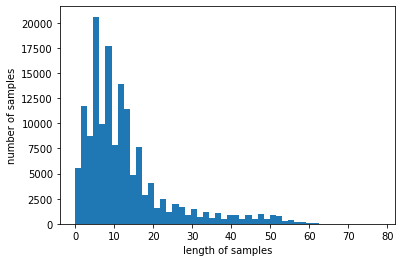

In [97]:
print('리뷰의 최대 길이 :',max(len(l) for l in train))
print('리뷰의 평균 길이 :',sum(map(len, train))/len(train))
plt.hist([len(s) for s in train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [98]:
print(train[0:2])
print(len(train))
print(len(test))

[[54, 430, 19, 6416, 621], [915, 439, 48, 575, 2, 198, 1456, 25, 931, 6417, 26053]]
150000
50000


#### Padding

In [379]:
max_len = args.max_len

train_X = train
eval_X = test[:25000]
test_X = test[25000:]

train_y = train_dt.label

test_y = test_dt.label
eval_y = test_y[:25000]
test_y = test_y[25000:]

#pack_padded_sequence(train_X,lengths=args.max_len,batch_first=True)
train_X = pad_sequences(train_X, maxlen = max_len, padding='post')
eval_X = pad_sequences(eval_X, maxlen=max_len,padding='post')
test_X = pad_sequences(test_X, maxlen = max_len,padding='post')

In [380]:
class mydataset(Dataset):

    def __init__(self,X,y):
        self.data = X
        self.target = y

    def __getitem__(self, index):

        x = self.data[index]
        y = self.target[index]

        return x,y

    def __len__ (self):

        return len(self.data)


In [381]:
ctrain_set = mydataset(train_X,train_y)
ceval_set = mydataset(eval_X,eval_y)
ctest_set = mydataset(test_X,test_y)

train_loader = DataLoader(ctrain_set,args.batch_size,shuffle=True)
eval_loader = DataLoader(ceval_set,args.batch_size)
test_loader = DataLoader(ctest_set,1)

print(len(train_loader.dataset))
print(len(eval_loader.dataset))
print(len(test_loader.dataset))

150000
25000
25000


# Model

### GRU

In [395]:
vocab_size = len(ctrain_set)


class GRU(nn.Module):
    def __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes, dropout_p=0.2):
        super(GRU, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embed = nn.Embedding(n_vocab, embed_dim, padding_idx=0)
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(embed_dim, self.hidden_dim,
                          num_layers=self.n_layers,
                          batch_first=True)
        self.out = nn.Linear(self.hidden_dim, n_classes)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self,x):
        
        x = self.embed(x)

        h_0 = self._init_state(batch_size=args.batch_size) # 첫번째 히든 스테이트를 0벡터로 초기화
        x, _ = self.gru(x, h_0)  # GRU의 리턴값은 (배치 크기, 시퀀스 길이, 은닉 상태의 크기)
        h_t = x[:,-1,:] # (배치 크기, 은닉 상태의 크기)의 텐서로 크기가 변경됨. 즉, 마지막 time-step의 은닉 상태만 가져온다.
        x = self.dropout(h_t)
        logit = self.sigmoid(self.out(x))  # (배치 크기, 은닉 상태의 크기) -> (배치 크기, 출력층의 크기)

        return logit

    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()


model = GRU(args.n_layers, args.hidden_dim, vocab_size, args.embbed_dim, args.n_classes, args.dropout_p)
print(model)

GRU(
  (embed): Embedding(150000, 64, padding_idx=0)
  (dropout): Dropout(p=0.3, inplace=False)
  (gru): GRU(64, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


### LSTM

In [413]:
class LSTM(nn.Module):
    def __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes, dropout_p=0.2):
        super(LSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embed = nn.Embedding(n_vocab, embed_dim)
        self.dropout = nn.Dropout(dropout_p)
        self.lstm = nn.LSTM(embed_dim, self.hidden_dim,
                          num_layers=self.n_layers,
                          batch_first=True
                          )
        
        self.out = nn.Linear(self.hidden_dim, n_classes)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x):
        x = self.embed(x)
        h_0 = self._init_state(batch_size=x.size(0)) # 첫번째 히든 스테이트를 0벡터로 초기화
        c_0 = self._init_state(batch_size=x.size(0))
        x, (h_out,_) = self.lstm(x, (c_0,h_0))  # GRU의 리턴값은 (배치 크기, 시퀀스 길이, 은닉 상태의 크기)
        h_t = self.dropout(x)
        logit = self.sigmoid(self.out(h_t))  # (배치 크기, 은닉 상태의 크기) -> (배치 크기, 출력층의 크기)

        return logit

    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()

LSTMmodel = LSTM(args.n_layers,args.hidden_dim,vocab_size,args.embbed_dim,args.n_classes,args.dropout_p)

# Training

#### Ealry Stopping

In [397]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...\n')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss



#### Train

#### acc fn

In [398]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

def get_accuracy_from_logits(logits, labels):
    #Get a tensor of shape [B, 1, 1] with probabilities that the sentiment is positive
    probs = torch.sigmoid(logits.unsqueeze(-1))
    #Convert probabilities to predictions, 1 being positive and 0 being negative
    soft_probs = (probs > 0.5).long()
    #Check which predictions are the same as the ground truth and calculate the accuracy
    acc = (soft_probs.squeeze() == labels).float().mean()
    return acc

### Implementation

In [419]:
def training(model,mode='gru'):

    if mode =='gru':
            
        model_path = '/content/drive/MyDrive/models'
        print(f'사용기기: {device}')
        optimizer = optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
        criterion = nn.BCEWithLogitsLoss()

   
        model.to(device)
        train_losses=[]
        val_losses = []
        val_accuracies = []
        avg_losses=[]
        total_loss = 0
        earlystop = EarlyStopping(patience=args.patience, verbose=True)

        for epoch in range(args.epochs):

            model.train()
            for idx, batch in enumerate(train_loader):

                text = batch[0].to(torch.int64).to(device)
                label = batch[1].to(device).type(torch.float).unsqueeze(1)
                optimizer.zero_grad()

                output = model(text)
                loss = criterion(output,label)
                loss.backward()
                optimizer.step()

                if idx % 1000 == 0:
                    print('Batch: %d      Loss: %5.5f' % (idx,loss))

            model.eval()
            corrects,val_loss = 0, 0
            for idx,batch in enumerate(eval_loader):
                
                text = batch[0].to(torch.int64).to(device)
                label = batch[1].to(device).type(torch.float).unsqueeze(1)
                
                output = model(text)
                val_loss = criterion(output, label)
                total_loss += val_loss.item()
                corrects = get_accuracy_from_logits(output, label)

            train_losses.append(loss)
            val_losses.append(val_loss)
                
            size = len(eval_loader.dataset)
            avg_loss = total_loss / size
            avg_losses.append(avg_loss)
            avg_accuracy = corrects
            print("===== epoch: %d   validation_avg_loss: %5.6f     validation_avg_accuracy:%5.2f ======" % (epoch,avg_loss,avg_accuracy))

            earlystop(val_loss, model)

            if earlystop.early_stop:
                print("Early stopping")
                break

            torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/JJY/models/sentiment_analysis/gru+str(now).pt')

    elif mode =='lstm':

        model_path = '/content/drive/MyDrive/models'
        print(f'사용기기: {device}')
        optimizer = optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
        criterion = nn.BCELoss()

        model = LSTMmodel
        model.to(device)
        train_losses=[]
        val_losses = []
        val_accuracies = []
        avg_losses=[]
        total_loss = 0
        earlystop = EarlyStopping(patience=args.patience, verbose=True)

        for epoch in range(args.epochs):

            model.train()
            for idx, batch in enumerate(train_loader):

                text = batch[0].to(torch.int64).to(device)
                label = batch[1].to(device).type(torch.float).unsqueeze(1)
                optimizer.zero_grad()

                print(text.size())
                print(label.size())
                output = model(text).squeeze(0)
                print(output.size())
                loss = criterion(output,label)
                loss.backward()
                optimizer.step()

                if idx % 1000 == 0:
                    print('Batch: %d      Loss: %5.5f' % (idx,loss))

            model.eval()
            corrects,val_loss = 0, 0
            for idx,batch in enumerate(eval_loader):
                
                text = batch[0].to(torch.int64).to(device)
                label = batch[1].to(device).type(torch.float).unsqueeze(1)
                
                output = model(text).squeeze(0)
                val_loss = criterion(output, label)
                total_loss += val_loss.item()
                corrects = get_accuracy_from_logits(output, label)

            train_losses.append(loss)
            val_losses.append(val_loss)
                
            size = len(eval_loader.dataset)
            avg_loss = total_loss / size
            avg_losses.append(avg_loss)
            avg_accuracy = corrects
            print("===== epoch: %d   validation_avg_loss: %5.6f     validation_avg_accuracy:%5.2f ======" % (epoch,avg_loss,avg_accuracy))

            earlystop(val_loss, model)

            if earlystop.early_stop:
                print("Early stopping")
                break

            torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/JJY/models/sentiment_analysis/lstm+str(now).pt')


#### run

In [420]:
training(LSTMmodel,mode='lstm')

사용기기: cuda:0
torch.Size([64, 30])
torch.Size([64, 1])
torch.Size([64, 30, 1])


ValueError: ignored

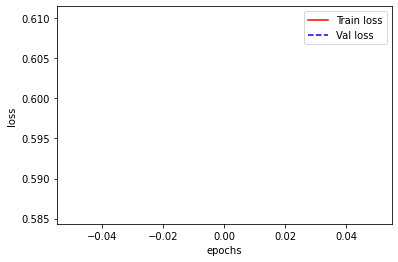

In [293]:
plt.plot(train_losses,'r-',label='Train loss')
plt.plot(val_losses,'b--',label='Val loss')
plt.xlabel('epochs')
plt.ylabel('loss')

plt.legend()
plt.show()

# Test

In [ ]:
model_load_path = '/content/drive/MyDrive/Colab Notebooks/JJY/models/sentiment_analysis/gru_sen_analysis2.pt'
model.load_state_dict(torch.load(model_load_path))

model.eval()
corrects,val_loss = 0, 0
for idx,batch in enumerate(zip(test_loader.dataset.data,test_loader.dataset.target)):
    
    text = torch.Tensor(batch[0]).to(torch.int64).to(device).unsqueeze(1)
    print(text)
    label = torch.Tensor(batch[1]).to(torch.int64).to(device)
    print(label)
    
    #label = torch.ensor(batch[1]).to(device)
        
    output = model(text)
    val_loss = criterion(output, label)
    total_loss += val_loss.item()
    corrects += (output.max(1)[1].view(label.size()).data == label.data).sum()

tensor([[  48],
        [   1],
        [ 713],
        [4303],
        [2426],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0],
        [   0]])
tensor([0])


ValueError: ignored

In [ ]:

def load_checkpoint(filepath):
    model.load_state_dict(torch.load(filepath))
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

model = load_checkpoint(model_load_path)

In [ ]:
def sentiment_predict(model,new_sentence):
  new_sentence = tok.morphs(new_sentence) # 토큰화
  encoded = tokenizer.texts_to_sequences(new_sentence) # 정수 인코딩
  encoded = [[x[0] for x in encoded]]
  pad_new = pad_sequences(encoded, maxlen = max_len,padding='post') # 패딩
  pad_new = torch.FloatTensor(pad_new).to(torch.int64).to(device)

  print(pad_new)
  score = model(pad_new) # 예측
  score = score.item()
  print(score)
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))


textin = '이 영화 노잼'
sentiment_predict(model,textin)

tensor([[  1,   2, 323,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0]])
0.006152578163892031
99.38% 확률로 부정 리뷰입니다.

